## BDEX Data Extraction

### Prereq:
- Python3.7+
- Run on `{BQNT /I:NOBOX <GO>}` and Trusted Kernel.
- Install the library first using:
    - !pip install aiohttp
    - !pip install minio

In [1]:
print("Please specify how many weeks of data you would like to extract:")
############# To manually change input ###################
number_of_weeks = 3
############# To manually change input ###################
print("You've specified "+str(number_of_weeks)+" weeks.")
print("Then please run all cells and find output in the folder bdex_output.")

Please specify how many weeks of data you would like to extract:
You've specified 3 weeks.
Then please run all cells and find output in the folder bdex_output.


### Main:

In [2]:
!pip install aiohttp

Looking in indexes: https://artifactory.inf.bloomberg.com/artifactory/api/pypi/bloomberg-pypi/simple


In [3]:
!pip install minio

Looking in indexes: https://artifactory.inf.bloomberg.com/artifactory/api/pypi/bloomberg-pypi/simple


In [4]:
import copy
from src.bdex_fe import (
    apply_and_filter,
    bdex_search,
    get_tags,
    GetData,
    PreProcessor,
)
from src.bdex_fe.products import bnef

In [5]:
query_tags = get_tags(product="bnef", number_of_weeks=number_of_weeks)
query_tags

['dskt2.AswoNewsStory.week.202231',
 'dskt2.AswoNewsStory.week.202230',
 'dskt2.AswoNewsStory.week.202229']

In [6]:
# from sample_data import all_recs
all_recs = await bdex_search(
    query_tags,
    proxy=None  # not needed on (?:nj|ny)lxdev\d or CORP
)

In [7]:
TAG_FILTERS = {  # example
    "and_tags": [  # contains all
#         "dskt2.AswoNewsStory.language.ENGLISH",
#         "dskt2.AswoNewsStory.jflo.indexed.true"
    ],
    "or_tags": [  # contains any
        
    ],
    "no_tags": [  # contains none
        
    ],
    "any_substr": [  # contains in any
#         "AswoNewsStory"
    ],
}
GET_DATA = {
    "doc_needed": False,
    "source_data_needed": False,
    # if any of the above are True, fill these:
    "bcos_account": None,
    "bcos_secret": None,
    "minio_access": None,
    "minio_secret": None
}

functions = []
preproc = PreProcessor(**TAG_FILTERS)
get_data_client = GetData(**GET_DATA)

product_specific_extraction_functions = [bnef.extract_suid, bnef.extract_resolution]


functions = (preproc.functions +
             product_specific_extraction_functions +
             get_data_client.functions +
             [])  # potential tokenisers

In [8]:
recs = copy.deepcopy(all_recs)
for f in functions:
    apply_and_filter(recs, f)

processing extract_tags                 :   7281 records |███████████| 100%[-00:00,  235253.50 records/s] 00:00
processing extract_suid                 :   7281 records |███████████| 100%[-00:00,  384241.27 records/s] 00:00
processing extract_resolution           :   7281 records |███████████| 100%[-00:00,  456271.79 records/s] 00:00


In [9]:
recs[0]

{'tags': ['dskt2.AswoNewsStory.BNEF-1017083.resolution_time.2022-08-01T12:41:45.185Z',
  'dskt2.AswoNewsStory.BNEF-1017083.financing_id.NA',
  'dskt2.AswoNewsStory.BNEF-1017083.asset_id.NA',
  'dskt2.AswoNewsStory.BNEF-1017083.reason.Record already up-to-date',
  'dskt2.AswoNewsStory.jflo.indexed.true',
  'dskt2.AswoNewsStory.BNEF-1017083.region.EMEA',
  'dskt2.AswoNewsStory.jflo.week.202231',
  'dskt2.AswoNewsStory.BNEF-1017083.resolution.Rejected',
  'dskt2.AswoNewsStory.jflo.issue.BCE-35642',
  'dskt2.AswoNewsStory.jflo.created.true',
  'dskt2.AswoNewsStory.jflo.issue.BNEF-1017083',
  'dskt2.AswoNewsStory.week.202231',
  'dskt2.AswoNewsStory.spam_score.26',
  'dskt2.AswoNewsStory.region_score.100',
  'dskt2.AswoNewsStory.class.19776',
  'dskt2.AswoNewsStory.suid.RFXRGLMB2SJQ',
  'dskt2.AswoNewsStory.language.ENGLISH',
  'dskt2.AswoNewsStory.arrivalTime.2022-08-01T12:17:09.620Z',
  'dskt2.AswoNewsStory.wireId.1806',
  'dskt2.AswoNewsStory.topicClusterId.WvEZYC8ai3H0WId52irZWMw==',
  

### Exporting as a Table via Reverse Engineering

In [10]:
import pandas as pd
from datetime import date
import re

today = date.today()

def tags_list_to_dict(cell):
    tags_dict = dict()
    issue_info_list = [] # to store info starting with 'dskt2.AswoNewsStory.BNEF-xxxxxx.'
    for i in cell:
        #jflo related tags
        if i.startswith('dskt2.AswoNewsStory.jflo.indexed.'):
            tags_dict['jflo.indexed'] = i.partition('dskt2.AswoNewsStory.jflo.indexed.')[2]
        if i.startswith('dskt2.AswoNewsStory.jflo.created.'):
            tags_dict['jflo.created'] = i.partition('dskt2.AswoNewsStory.jflo.created.')[2]  
        if i.startswith('dskt2.AswoNewsStory.jflo.week.'):
            tags_dict['jflo.week'] = i.partition('dskt2.AswoNewsStory.jflo.week.')[2] 
            
        # non-archived
        if i.startswith('dskt2.AswoNewsStory.jflo.issue.'):
            # there might be multiple issues per source, recording the existence of such
            jflo_id = i.partition('dskt2.AswoNewsStory.jflo.issue.')[2]  
            if 'jflo.issue' in tags_dict.keys():
                if str(tags_dict['jflo.issue']) != str(jflo_id):
                    tags_dict['multiple_issue'] = "Yes"
                    tags_dict['jflo.issue'] = jflo_id # regard the one with 'jflo.issue' prefix as the dominant one
            else:
                tags_dict['jflo.issue'] = jflo_id
        # archived: here we take the first BNEF id in the string as 'jflo.issue'
        if i.startswith('dskt2.AswoNewsStory.BNEF-'):
            m = re.search('dskt2.AswoNewsStory.BNEF-(.+?)\.', i)
            if m:
                jflo_id = 'BNEF-'+m.group(1)            
                # there might be multiple issues per source, recording the existence of such
                if 'jflo.issue' in tags_dict.keys():
                    if str(tags_dict['jflo.issue']) != str(jflo_id):
                        tags_dict['multiple_issue'] = "Yes"
                else:
                    tags_dict['jflo.issue'] = jflo_id  
                    
        #source related tags
        if i.startswith('dskt2.AswoNewsStory.wireId.'):
            tags_dict['wireId'] = i.partition('dskt2.AswoNewsStory.wireId.')[2]
        if i.startswith('dskt2.AswoNewsStory.wireCode.'):
            tags_dict['wireCode'] = i.partition('dskt2.AswoNewsStory.wireCode.')[2]        
        if i.startswith('dskt2.AswoNewsStory.class.'):
            tags_dict['class'] = i.partition('dskt2.AswoNewsStory.class.')[2]
        if i.startswith('dskt2.AswoNewsStory.suid.'):
            tags_dict['tags_suid'] = i.partition('dskt2.AswoNewsStory.suid.')[2]
        if i.startswith('dskt2.AswoNewsStory.headline.'):
            tags_dict['headline'] = i.partition('dskt2.AswoNewsStory.headline.')[2]        
        if i.startswith('dskt2.AswoNewsStory.topicClusterId.'):
            tags_dict['topicClusterId'] = i.partition('dskt2.AswoNewsStory.topicClusterId.')[2]     
        if i.startswith('dskt2.AswoNewsStory.niCodes.'):
            tags_dict['niCodes'] = i.partition('dskt2.AswoNewsStory.niCodes.')[2]          
        if i.startswith('dskt2.AswoNewsStory.language.'):
            tags_dict['language'] = i.partition('dskt2.AswoNewsStory.language.')[2]           
        if i.startswith('dskt2.AswoNewsStory.arrivalTime.'):
            tags_dict['arrivalTime'] = i.partition('dskt2.AswoNewsStory.arrivalTime.')[2]  
        #other info
        if i.startswith('dskt2.AswoNewsStory.region_score.'):
            tags_dict['region_score'] = i.partition('dskt2.AswoNewsStory.region_score.')[2]    
        if i.startswith('dskt2.AswoNewsStory.region.'):
            tags_dict['region'] = i.partition('dskt2.AswoNewsStory.region.')[2]          
        if i.startswith('dskt2.AswoNewsStory.spam_score.'):
            tags_dict['spam_score'] = i.partition('dskt2.AswoNewsStory.spam_score.')[2] 
        if i.startswith('dskt2.AswoNewsStory.week.'):
            tags_dict['week'] = i.partition('dskt2.AswoNewsStory.week.')[2]   
        #currently not including details related to individual jflo issues that were clones
        #individual issue info
        if i.startswith('dskt2.AswoNewsStory.BNEF-'):
            issue_info_list.append(i.partition('dskt2.AswoNewsStory.')[2])    
    #iterate to record key JFLO issue details into dictionary
    if 'jflo.issue' in tags_dict:
        prefix = tags_dict['jflo.issue'] 
        for i in issue_info_list:
            if i.startswith(prefix + '.region.'):
                tags_dict['jflo_region'] = i.partition(prefix + '.region.')[2]   
            if i.startswith(prefix + '.asset_id.'):
                tags_dict['jflo_asset_id'] = i.partition(prefix + '.asset_id.')[2]             
            if i.startswith(prefix + '.resolution_time.'):
                tags_dict['jflo_resolution_time'] = i.partition(prefix + '.resolution_time.')[2]             
            if i.startswith(prefix + '.reason.'):
                tags_dict['jflo_reason'] = i.partition(prefix + '.reason.')[2]               
            if i.startswith(prefix + '.financing_id.'):
                tags_dict['jflo_financing_id'] = i.partition(prefix + '.financing_id.')[2]    
            if i.startswith(prefix + '.resolution.'):
                tags_dict['jflo_resolution'] = i.partition(prefix + '.resolution.')[2]  
    return tags_dict

In [11]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

comb = pd.DataFrame()
for r in recs:
    temp = pd.DataFrame(list(r.items())).set_index(0).transpose()
    comb = comb.append(temp)
#unstack tags content into multiple columns    
res = comb['tags'].apply(tags_list_to_dict).apply(pd.Series)
res = pd.concat([comb.drop(['tags'], axis=1), res], axis=1)
res.head()

,doc_sha,document,sourcedata,mime_type,asof,suid,resolution,jflo.issue,jflo.indexed,jflo.week,multiple_issue,jflo.created,week,spam_score,region_score,class,tags_suid,language,arrivalTime,wireId,topicClusterId,region,niCodes,headline,wireCode,jflo_resolution_time,jflo_financing_id,jflo_asset_id,jflo_reason,jflo_region,jflo_resolution
1,d935f9cb118b945197923f19a97d052e8ada5b2b544ee9...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-01T12:17:10.552000+00:00,RFXRGLMB2SJQ,Rejected,BNEF-1017083,true,202231,Yes,true,202231,26,100,19776,RFXRGLMB2SJQ,ENGLISH,2022-08-01T12:17:09.620Z,1806,WvEZYC8ai3H0WId52irZWMw==,EMEA,GDNEFWIND,Windpower E&D: First order of Siemens Gamesa r...,NS1,2022-08-01T12:41:45.185Z,NA,NA,Record already up-to-date,EMEA,Rejected
1,e6f0f3ce98307e83d81407293be77c64adfae75ae47c85...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-01T12:15:31.639000+00:00,RFXRDUBSWSG1,Rejected,BNEF-1017080,true,202231,Yes,true,202231,66,100,7,RFXRDUBSWSG1,ENGLISH,2022-08-01T12:15:30.741Z,2691,TfWt2+6M3MNMOuct8XqBZVg==,EMEA,GDNEFSOLAR,Germany adds 3.2 GW of solar 1 GW of onshore w...,AII,2022-08-01T12:22:49.213Z,NA,NA,Not enough information for update,EMEA,Rejected
1,d3f5be402513444ae9361d5c8ead996c09266e98b88db4...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-01T16:27:28.512000+00:00,RFY31RC60R9C,Rejected,BCE-35767,true,202231,Yes,true,202231,92,92,2,RFY31RC60R9C,ENGLISH,2022-08-01T16:27:27.606Z,956,Th9S7UVqAoP9G0azqZOqCzw==,AMER,GDNEFWIND,New York solicits 2 GW of offshore wind,ITN,NaN,NaN,NaN,NaN,NaN,NaN
1,a7596c1dad9b08e4088fa744b39b09739cce64ba88b48b...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-01T06:00:10.474000+00:00,RFXA080C92BV,Rejected,BNEF-1016722,true,202231,Yes,true,202231,40,100,151,RFXA080C92BV,ENGLISH,2022-08-01T06:00:08.866Z,89,RFXA080C92BV==,EMEA,GDNEFSOLAR,JLEN Environmental JLEN Acquisition,RNS,2022-08-01T14:23:46.156Z,NA,NA,Record already up-to-date,EMEA,Rejected
1,c5f50ddc9e4cf72d98fc41af343a202bbe6875a9873d52...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-01T14:31:37.535000+00:00,RFXXOOMB2SJV,Rejected,BNEF-1017208,true,202231,Yes,true,202231,30,100,6122,RFXXOOMB2SJV,ENGLISH,2022-08-01T14:31:36.695Z,1806,WGbzmQ1NihdjtElDSpQRY6g==,EMEA,GDNEFWIND,Offshore: Recyclable wind turbine blades opera...,NS1,2022-08-01T14:48:07.914Z,NA,NA,Record already up-to-date,EMEA,Rejected


In [13]:
# to avoid Excel's limit of 65,530 URLS per worksheet
writer = pd.ExcelWriter('bdex_output/res-'+str(today)+'.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
res.to_excel(writer)
writer.close()

# Major Rejected Sources 

In [14]:
#filter jflo_Resolution = "Rejected"
newRes=res[res['jflo_resolution']=='Rejected']
#find duplicate of combinations (class+wireId) from rejected 
newRes=newRes[newRes.duplicated(['class','wireId'], keep=False)]

#counts duplicate sources
duplicateCount= newRes.pivot_table(index = ['wireId', 'class'], aggfunc ='size')

duplicateCount=duplicateCount.reset_index()
duplicateCount.columns = ['wireId', 'class', 'count']

import numpy as np
duplicateCount['rejection%']=(duplicateCount['count']/res.shape[0]*100)

In [28]:
#widget for threshold
import ipywidgets as widgets
from IPython.display import display

w = widgets.IntText(
    value = 10,
    description ='Major Rejection Threshold',
    diabled = False,
    style={'description_width': 'initial'}
)
display(w)

IntText(value=10, description='Major Rejection Threshold', style=DescriptionStyle(description_width='initial')…

In [33]:
#finds sources that has been rejected more than certain threshold
duplicateCount.drop(duplicateCount[duplicateCount['count'] < w.value].index, inplace = True)
majorRej=duplicateCount
majorRej=majorRej.reset_index(drop=True)

In [34]:
#rejection reason for duplicate sources(wire+class)

#DOES NOT ACCOUNT FOR THRESHOLD     
countReason= newRes.pivot_table(index = ['wireId', 'class', 'jflo_reason'], aggfunc ='size')
countReason=countReason.reset_index()

#grabbing only the major rejects reasons --threshold

majorRejRes=countReason.merge(majorRej, on=['wireId','class'],how='inner')
majorRejRes=majorRejRes.drop(['count','rejection%'], axis=1)
majorRejRes.columns=['wireId', 'class', 'jflo_reason', 'count']


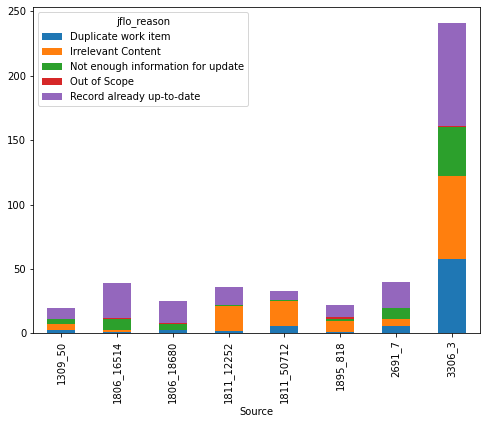

In [35]:
#make stacked graph 
# x-axis = source
# y-axis = count (group by jflo reason)
# stacked = jflo_reason

majorRejRes['Source'] = majorRejRes['wireId'] + '_' + majorRejRes['class']

majorRejRes = majorRejRes.pivot_table(index=['Source'], columns = ['jflo_reason'], values='count')
rejection_reasons = majorRejRes.plot.bar(stacked=True, figsize=(8,6))

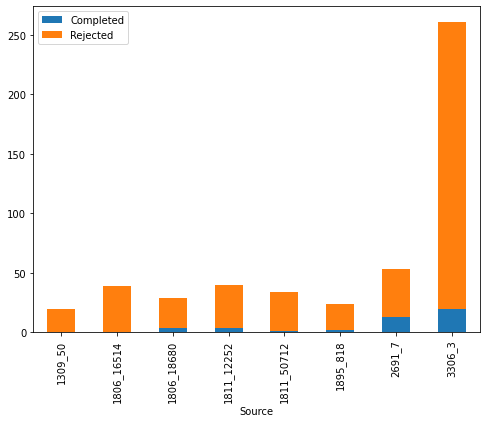

In [36]:
#stacked chart to see how many completed resolutions would be lost if rejected source becomes omitted 

res['Source'] = res['wireId']+'_'+ res['class']
successLoss= res.pivot_table(index=['Source'], columns = ['jflo_resolution'], aggfunc='size')

majorRej['Source'] = majorRej['wireId']+'_'+ majorRej['class']
successLoss=pd.merge(successLoss.reset_index(), majorRej, how='inner').set_index('Source')

successLoss = successLoss.drop(['wireId','class','rejection%','count'], axis=1)
successLoss= successLoss.plot.bar(stacked=True, figsize=(8,6))
